In [1]:
pip install --upgrade pydot pyparsing

Note: you may need to restart the kernel to use updated packages.


In [94]:
import pydot
import random
import math
import matplotlib.pyplot as plt
import networkx as nx
from statistics import mean
import numpy as np
from numpy import linalg as LA

In [93]:
def parse_dot_file(file_path):
    graph = pydot.graph_from_dot_file(file_path)[0]  # Get the first graph from the list
    nodes = []
    edges = []
    for node in graph.get_nodes():
        nodes.append(node.get_name())
    for edge in graph.get_edges():
        source = edge.get_source()
        target = edge.get_destination()
        attributes = edge.get_attributes()
        edges.append((source, target, attributes))
    return nodes, edges

file_path = r"C:\Users\31642\Downloads\noname.dot"
#LesMiserables, LeagueNetwork, polblogs
nodes, edges = parse_dot_file(file_path)

print("Nodes:", nodes)
print("Edges:")
for edge in edges:
    print(edge)

Nodes: ['5', '13', '3', '6', '14', '15', '7', '11', '8', '9', '16', '10', '4', '2', '18', '17', '19', '20', '12', '21', '22', '1', '23', '24']
Edges:
('5', '13', {})
('13', '3', {})
('3', '15', {})
('6', '14', {})
('14', '21', {})
('15', '7', {})
('7', '18', {})
('11', '8', {})
('11', '9', {})
('9', '1', {})
('16', '10', {})
('16', '2', {})
('4', '9', {})
('2', '17', {})
('18', '3', {})
('17', '16', {})
('17', '3', {})
('19', '20', {})
('20', '12', {})
('20', '6', {})
('12', '8', {})
('21', '19', {})
('21', '11', {})
('22', '3', {})
('1', '23', {})
('23', '12', {})
('24', '16', {})


## Step 1

In [95]:
# Function to arrange nodes in a square-like layout
def arrange_in_square(nodes):
    num_nodes = len(nodes)
    side_length = int(math.ceil(math.sqrt(num_nodes)))
    spacing = 50
    start_x, start_y = -((side_length - 1) * spacing) / 2, ((side_length - 1) * spacing) / 2
    node_positions = {}
    current_x, current_y = start_x, start_y
    for i, node in enumerate(nodes):
        node_positions[node] = (current_x, current_y)
        current_x += spacing

        if (i + 1) % side_length == 0:
            current_x = start_x
            current_y -= spacing  # Move to the next row
    return node_positions

def arrange_in_radial(nodes):
    num_nodes = len(nodes)
    radius = 200
    angle_step = 360 / num_nodes
    node_positions = {}
    for i, node in enumerate(nodes):
        angle = math.radians(i * angle_step)
        x = radius * math.cos(angle)
        y = radius * math.sin(angle)
        node_positions[node] = (x, y)
    return node_positions

def arrange_in_semi_square(nodes):
    num_nodes = len(nodes)
    side_length = int(math.ceil(math.sqrt(num_nodes)))  # Calculate the side length of the square
    spacing = 60  # Spacing between nodes
    start_x, start_y = -((side_length - 1) * spacing) / 2, ((side_length - 1) * spacing) / 2
    node_positions = {}
    current_x, current_y = start_x, start_y
    for i, node in enumerate(nodes):
        node_positions[node] = (current_x, current_y + random.randint(-15, 15))
        current_x += spacing

        if (i + 1) % side_length == 0:
            current_x = start_x
            current_y -= spacing  # Move to the next row

    return node_positions

In [247]:
def draw_node_link_diagram(nodes, edges, node_positions, node_colors, node_size=300, directed=False): 
    fig, ax = plt.subplots()
               
    # Draw nodes and labels
    for node, pos in node_positions.items():
        ax.scatter(pos[0], pos[1], s=node_size, color=node_colors[node], edgecolors='dimgray', zorder=5)  # Draw node
        ax.text(pos[0], pos[1], node[0:4], ha='center', va='center', fontsize=8, zorder=10)  # Add label
     
    # Draw edges
    for edge in edges:
        source, target, _ = edge
        start = node_positions[source]
        end = node_positions[target]
        
        if directed == False:
            ax.plot([start[0], end[0]], [start[1], end[1]], color=node_colors[source])  # Draw edge
        else:
            ax.arrow(start[0], start[1], end[0]-start[0], end[1]-start[1], length_includes_head=True, head_width = np.sum(np.abs(ax.get_xlim()))/40, color=node_colors[source], zorder=0) # Draw arrow
            # Use geometric libraries to smooth edges

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

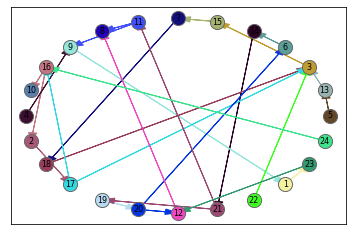

In [248]:
main(nodes, edges, "radial", node_size=200, directed=True)

In [171]:
# Main function to draw the node-link diagram using Matplotlib
def main(nodes, edges, structure='square', node_size=300, root=None, search_algorithm=False, search_root=None, directed=False): 
    # Arrange nodes in a structure
    if structure =='square':
        node_positions = arrange_in_square(nodes)
    elif structure == 'radial':
        node_positions = arrange_in_radial(nodes)
    elif structure == 'semi_square':
        node_positions = arrange_in_semi_square(nodes)
    elif structure == 'tree':
        node_positions = arrange_in_tree(nodes, edges, root)
    elif structure == 'force':
        node_positions = arrange_in_force(nodes,edges)
        
    #add random color to each node (as node:colorvalue)
    node_colors = {}
    for node in nodes:
        node_colors[node] = "#" + ''.join(random.choices('0123456789ABCDEF', k=6)) #create random 6 hex code for color (which networkx uses)

    draw_node_link_diagram(nodes, edges, node_positions, node_colors, node_size, directed)
    if search_algorithm:
        search_through_tree(nodes, edges, node_positions, node_colors, search_root, node_size)

### Step 2

#### Tree

In [36]:
def arrange_in_tree(nodes, edges, root=None):
    num_nodes = len(nodes)
    node_positions = {}
    if root == None:
        root = nodes[0]
        
    node_positions[root] = (0, 0) 
    layer_space = 1
    node_space = 1
    padding = 10

    queue = [root]
    past_nodes = []
    '''Tree creation'''
    while queue != []:
        current_node = queue[0]
        connected_edges = [t[:2] for t in edges if current_node in t[:2]] 
        children_nodes = [value for tuple in connected_edges for value in tuple if value != current_node and value not in past_nodes]
        if children_nodes != []: 
            segment_length = node_space / len(children_nodes)
            parent_coords = node_positions[current_node]
            for i, children_node in enumerate(children_nodes):
                if children_node not in node_positions:
                    new_x = -node_space/2+segment_length*(0.5+i)
                    new_y = parent_coords[1]-layer_space
                    node_positions[children_node] = (new_x, new_y)
            queue = children_nodes + queue
        queue.remove(current_node)
        past_nodes.append(current_node)
        
        
    '''Improve node positions in tree '''
    #this part will calculate what the max and min x&y-coordinate for the graph to determine the most rightest & leftest etc. place
    layer_min_max = {} 
    for node, node_pos in node_positions.items():
        layer = node_pos[1] #y-as
        x_coord = node_pos[0] #x-as
        if layer not in layer_min_max:
            layer_min_max[layer] = [x_coord, x_coord]
        else:
            if x_coord < layer_min_max[layer][0]:
                layer_min_max[layer][0] = x_coord
            if x_coord > layer_min_max[layer][1]:
                layer_min_max[layer][1] = x_coord

    # Move nodes which are already in the same layer and divide them equally through the layer
    for layer, (min_x, max_x) in layer_min_max.items():
        layer_nodes = [(node, pos) for node, pos in node_positions.items() if pos[1] == layer]
#         if len(layer_nodes) > 5:
        if len(layer_nodes) > 2: #TODO fix visual
            interval = (max_x - min_x) / (len(layer_nodes) - 1)
            for i, (node, pos) in enumerate(layer_nodes):
                new_x = min_x + i * interval
                node_positions[node] = (new_x, pos[1])
#             print(node_positions)
        elif layer_nodes[0][1][1] < 0: #check if not first layer and not a lot of nodes, connected them with their parents by giving the parent's node x-as
            for i, layer_node in enumerate(layer_nodes):
                parent_node = [parent_node[0] for parent_node in edges if parent_node[1] == layer_node[0]]
                middle_parent_node_coords = mean([parent_node_coords[1][0] for parent_node_coords in previous_layer_nodes if parent_node_coords[0] in parent_node])
                node_positions[layer_node[0]] = (middle_parent_node_coords, layer_node[1][1])
        layer_nodes = [(node, pos) for node, pos in node_positions.items() if pos[1] == layer]        
        previous_layer_nodes = layer_nodes.copy()
    return node_positions

#### Search Algorithms

In [25]:
def search_through_tree(nodes, edges, node_positions, node_colors, search_root=None, node_size=200):
    org_edges = edges.copy() #saves the original edges
    print("DFS:")
    '''DFS'''
    num_nodes = len(nodes)
    if search_root == None:
        search_root = nodes[0]
    stack = [search_root]
    visited = []
    DFS_edges = []
    while stack != []:
        current_node = stack[0]
        connected_edges = [t[:2] for t in edges if current_node in t[:2]] 
        connected_edges = sorted(connected_edges, key=lambda x: int(x[1]))
        children_nodes = [value for tuple in connected_edges for value in tuple if value != current_node and value not in visited]        
        if children_nodes != []:
            for children_node in children_nodes:
                if children_node in stack:
                    stack.remove(children_node)
                stack[stack.index(current_node):stack.index(current_node)] = [children_node]
            for edge in edges:
                if (edge[0] == current_node and edge[1] == children_nodes[0] 
                     and edge[1] not in [elem[1] for elem in DFS_edges]): #same source and if target is first edge
                    DFS_edges.append(edge)
                elif (edge[1] == current_node and edge[0] == children_nodes[0]
                      and edge[0] not in [elem[0] for elem in DFS_edges]): #viceversa cuz undirected
                    DFS_edges.append((edge[1], edge[0], edge[2]))
        elif len(visited) != len(nodes):
            stack.insert(0,[elem[0] for elem in DFS_edges if elem[1] == current_node][0])
        if current_node not in visited:
            visited.append(current_node)
        stack.remove(current_node)
        
    print('Visited', visited)
    DFS_node_positions = arrange_in_tree(nodes, DFS_edges, search_root)
    draw_node_link_diagram(visited, DFS_edges, DFS_node_positions, node_colors, node_size)
    
    '''Restoring original values'''
    print("BFS:")
    '''BFS'''
    BFS_edges = []
    num_nodes = len(nodes)
    if search_root == None:
        search_root = nodes[0]
    queue = [search_root]
    visited = []
    while queue != []:
        current_node = queue[0]
        connected_edges = [t[:2] for t in edges if current_node in t[:2]] 
        connected_edges = sorted(connected_edges, key=lambda x: int(x[1]))
        children_nodes = [value for tuple in connected_edges for value in tuple if value != current_node and value not in visited]
        if children_nodes != []:
            for children_node in children_nodes:
                if children_node not in queue:
                    queue.append(children_node)
                for edge in edges:
                    if (edge[0] == current_node and edge[1] == children_node
                       and edge[1] not in [elem[1] for elem in BFS_edges]): #same source and if target is first edge
                        BFS_edges.append(edge)
                    elif (edge[1] == current_node and edge[0] == children_node
                          and edge[0] not in [elem[0] for elem in BFS_edges]): #viceversa cuz undirected
                        BFS_edges.append((edge[1], edge[0], edge[2]))
        if current_node not in visited:
            visited.append(current_node)
        queue.remove(current_node)
    BFS_node_positions = arrange_in_tree(nodes, BFS_edges, search_root)

    print('Visited', visited)
    draw_node_link_diagram(visited, BFS_edges, BFS_node_positions, node_colors, node_size)
    
    print('DFS removed edges: ', [x[:2] for x in edges if x not in DFS_edges])
    print('BFS removed edges: ', [x[:2] for x in edges if x not in BFS_edges])

### 3

In [260]:
def arrange_in_force(nodes, edges):
    # choice of forces/parameters
    force_magnitude = 2
    k = 4
    l = 1
    delta = 0.5
    cspring = 2
    crep = 1
    
    node_positions = arrange_in_semi_square(nodes)
    num_nodes = len(nodes)
    
    t = 1
    while t < k:
        for node in nodes:
            fspring = []
            #fattr = 0
            frep = []
            current = 1
            while current <= num_nodes:
                if int(node) != current:
                    p_u = np.array(node_positions[node])
                    p_v = np.array(node_positions[f'{current}'])

                    direction = p_v - p_u
                    direction_unit = direction / np.linalg.norm(direction)
                    force = force_magnitude * direction_unit
                    p_u = p_u + force*delta

                    if (node, f'{current}', {}) in edges:
                        adjecent = True
                    else:
                        adjecent = False
                        
                    # Spring Embedder
                    # > Fruchterman and Reingold
                    if adjecent==True:
                        fspring.append(cspring / LA.norm(direction)**2 * pointing(p_v,p_u))
                        #fattr = (LA.norm(direction)**2 / l) * pointing(p_u,p_v)
                    elif adjecent==False:
                        frep.append(crep * math.log(LA.norm(direction)/l) * pointing(p_v,p_u))
                    
                    #frep = (l**2 / LA.norm(direction)) * pointing(p_u,p_v)
                    #fspring.append(frep + fattr)
                current += 1
            Fv = sum(fspring) + sum(frep)
            node_positions[node] = tuple(Fv)
        t += 1
    return node_positions

def pointing(p1,p2):
    return p2-p1 / LA.norm(p2-p1)

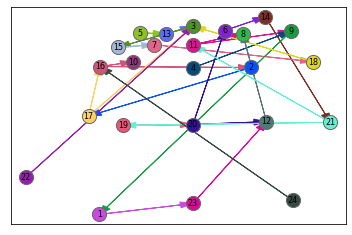

In [261]:
main(nodes, edges, "force", node_size=200, directed=True)

In [117]:
def fruchterman_and_reingold(nodes,edges):
    # l = C * sqrt(area/number of vertices) - l
    l = 1
    delta = 1
    cspring = 2
    crep = 1
    # all node pairs
    frep = (l**2 / LA.norm(p2-p1)) * pointing(p1,p2)
    # adjecent nodes
    fattr = (LA.norm(p2-p1)**2 / l) * pointing(p1,p2)
    # resulting
    fspring = frep + fattr
    return fspring